In [67]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from PIL import Image

In [68]:
od.download('https://www.kaggle.com/competitions/widsdatathon2019/data')

Skipping, found downloaded files in ".\widsdatathon2019" (use force=True to force download)


In [69]:
img_name = os.listdir("C:\\Users\\Jun Kim\\OneDrive\\Desktop\\LearningFuze\\widsdatathon2019\\train_images\\train_images")

In [73]:
train = pd.DataFrame(img_name, columns= ['name'])
train_label = pd.read_csv("C:\\Users\\Jun Kim\\OneDrive\\Desktop\\LearningFuze\\widsdatathon2019\\traininglabels.csv")

## only use data from 2017

In [74]:
train_label['year'] = train_label['image_id'].map(lambda x: x[9:] if x else x)
train_label = train_label[train_label['year'].str.startswith('2017')]
train_label.drop(columns= 'year', axis = 1, inplace= True)
train_label['image_id'] = train_label['image_id'].map(lambda x: x[0:9:]+x[13::] if x else x)
train_label = train_label[train_label['score'] == 1] # only use data that have 100 % score

In [75]:
train_hasoilpalm = train_label[train_label['has_oilpalm'] == 1]
train_hasoilpalm

,image_id,has_oilpalm,score
75,img_00113.jpg,1,1.0
129,img_00201.jpg,1,1.0
143,img_00223.jpg,1,1.0
155,img_00240.jpg,1,1.0
176,img_00272.jpg,1,1.0
...,...,...,...
7512,img_10965.jpg,1,1.0
7524,img_10982.jpg,1,1.0
7527,img_10985.jpg,1,1.0
7529,img_10987.jpg,1,1.0


In [59]:
train = train_label.merge(train, how = 'inner', right_on = 'name', left_on= 'image_id') # only get img_names that are in train_label
train = train['name']
train = pd.DataFrame(train)
train

,name
0,img_00001.jpg
1,img_00002.jpg
2,img_00007.jpg
3,img_00008.jpg
4,img_00009.jpg
...,...
6403,img_10989.jpg
6404,img_10993.jpg
6405,img_10995.jpg
6406,img_10996.jpg


In [64]:
train_hasoilpalm.drop(columns=['has_oilpalm', 'score'], inplace = True)

C:\Users\Jun Kim\AppData\Local\Temp\ipykernel_19628\3190876321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_hasoilpalm.drop(columns=['has_oilpalm', 'score'], inplace = True)


In [66]:
train_hasoilpalm

,image_id
75,img_00113.jpg
129,img_00201.jpg
143,img_00223.jpg
155,img_00240.jpg
176,img_00272.jpg
...,...
7512,img_10965.jpg
7524,img_10982.jpg
7527,img_10985.jpg
7529,img_10987.jpg


## get images into an array then scale by dividing the pixels by 255. 255 is the max pixel

In [34]:
train_list = []
for image in train['name']:
    path = "C:\\Users\\Jun Kim\\OneDrive\\Desktop\\LearningFuze\\widsdatathon2019\\train_images\\train_images\\"+image
    img_display = tf.keras.preprocessing.image.load_img(path, target_size= (32,32))
    img_display_array = tf.keras.preprocessing.image.img_to_array(img_display)
    train_list.append(img_display_array)
train_array = np.array(train_list)/255

In [39]:
x = train_array
y = train_label['has_oilpalm'].values
train_images, test_images, train_labels, test_labels = train_test_split(x,y, test_size = .33, random_state = 1)

In [10]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((4293, 32, 32, 3), (4293,), (2115, 32, 32, 3), (2115,))

In [11]:
vgg = VGG16(include_top=False, input_shape= (32,32,3))
flat_vgg = Flatten()(vgg.layers[-1].output)
dense_vgg = Dense(512, activation = 'relu')(flat_vgg)
dense_vgg2 = Dense(256, activation = 'relu')(dense_vgg)
dense_vgg3 = Dense(128, activation = 'relu')(dense_vgg2)
dense_vgg4 = Dense(64, activation = 'relu')(dense_vgg3)
dense_vgg5 = Dense(8, activation = 'relu')(dense_vgg4)
output_vgg = Dense(1, activation = 'sigmoid')(dense_vgg5)

model_vgg = Model(inputs = vgg.input, outputs = output_vgg)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'auc', patience = 5)

In [13]:
model_vgg.compile(optimizer= opt, loss = 'binary_crossentropy', metrics = ['AUC'])
history = model_vgg.fit(train_images, train_labels,  epochs = 50, batch_size= 30, callbacks = [callback], validation_data= (test_images, test_labels))

Epoch 1/50
144/144 [==============================] - 94s 643ms/step - loss: 0.1928 - auc: 0.7784 - val_loss: 0.1159 - val_auc: 0.9610
Epoch 2/50
144/144 [==============================] - 91s 633ms/step - loss: 0.1309 - auc: 0.9081 - val_loss: 0.1775 - val_auc: 0.9372
Epoch 3/50
144/144 [==============================] - 90s 626ms/step - loss: 0.1186 - auc: 0.9387 - val_loss: 0.0965 - val_auc: 0.9719
Epoch 4/50
144/144 [==============================] - 90s 627ms/step - loss: 0.0842 - auc: 0.9677 - val_loss: 0.0720 - val_auc: 0.9839
Epoch 5/50
144/144 [==============================] - 90s 626ms/step - loss: 0.0570 - auc: 0.9826 - val_loss: 0.0566 - val_auc: 0.9887
Epoch 6/50
144/144 [==============================] - 90s 627ms/step - loss: 0.0736 - auc: 0.9679 - val_loss: 0.0997 - val_auc: 0.9874
Epoch 7/50
144/144 [==============================] - 91s 635ms/step - loss: 0.0876 - auc: 0.9612 - val_loss: 0.0731 - val_auc: 0.9898
Epoch 8/50
144/144 [==============================] - 9

In [14]:
prediction = model_vgg.predict(test_images)

67/67 [==============================] - 4s 55ms/step


In [15]:
pred_df = pd.DataFrame(prediction)

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
pred_df.columns = ['pred']
pred_df

,pred
0,3.607631e-07
1,5.034838e-02
2,1.378878e-06
3,9.688733e-01
4,5.166868e-06
...,...
2110,4.976771e-05
2111,2.962931e-04
2112,1.224126e-05
2113,8.883851e-06


In [18]:
pred_df[pred_df['pred']>0.5]

,pred
3,0.968873
19,0.996164
26,0.962087
37,0.999678
52,1.000000
...,...
2034,1.000000
2040,1.000000
2068,0.999661
2092,1.000000


In [19]:
pred_df['pred'] = pred_df['pred'].map(lambda x: 0 if x < 0.5 else 1)

In [20]:
pred_df

,pred
0,0
1,0
2,0
3,1
4,0
...,...
2110,0
2111,0
2112,0
2113,0


In [21]:
test_labels.shape

(2115,)

In [22]:
roc_auc_score(test_labels, pred_df)

0.9245942527928054

In [23]:
precision_score(test_labels, pred_df)

0.9401709401709402

In [24]:
recall_score(test_labels, pred_df)

0.8527131782945736

In [25]:
accuracy_score(test_labels, pred_df)

0.9877068557919622

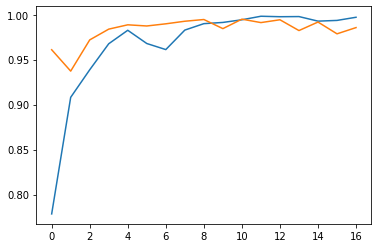

In [26]:
plt.plot(history.history['auc'], label = 'AUC')
plt.plot(history.history['val_auc'], label = 'VAL_AUC')

In [31]:
confusion_matrix(test_labels, pred_df) 

array([[1979,    7],
       [  19,  110]], dtype=int64)